In [1]:
# default_exp datasets

# HealKaha14 Dataset

> Healey, M. K., & Kahana, M. J. (2014). Is memory search governed by universal principles or idiosyncratic strategies?. Journal of Experimental Psychology: General, 143(2), 575.

The present analyses are based on the 126 young adult (age 18–30) participants who had completed Experiment 1 of PEERS as of December 2012. Participants performed a free recall experiment consisting of 1 practice session and 6 subsequent experimental sessions. Each session consisted of 16 lists of 16 words presented one at a time on a computer screen. Different lists had different encoding task conditions; here, we focus on the 28 lists for each subject that were studied with no explicit encoding task. Word association spaces similarity values (Steyvers et al., 2004) were used to group words into four similarity bins (high similarity: cos($\theta$) >= .7; medium–high similarity: .14 <= cos($\theta$) < .7; medium–low similarity: ; low similarity: cos($\theta$) < .14). In each list, two pairs of items from each of the groups were arranged such that one pair occurred at adjacent serial positions and the other pair was separated by at least two other items. Each word appeared for 3 s, followed by an inter-stimulus interval of 0.8–1.2 s.

In [3]:
# export

import scipy.io as sio
import numpy as np
import pandas as pd
from psifr import fr

def prepare_healkaha2014_data(path):
    """
    Prepares data formatted like `data/MurdData_clean.mat` for fitting.

    Loads data from `path` with same format as `data/MurdData_clean.mat` and
    returns a selected dataset as an array of unique recall trials and a
    dataframe of unique study and recall events organized according to `psifr`
    specifications.

    **Arguments**:
    - path: source of data file
    - dataset_index: index of the dataset to be extracted from the file

    **Returns**:
    - trials: int64-array where rows identify a unique trial of responses and
        columns corresponds to a unique recall index.
    - merged: as a long format table where each row describes one study or
        recall event.
    - list_length: length of lists studied in the considered dataset
    """

    # load all the data
    mat_file = sio.loadmat(path, squeeze_me=True)
    mat_data = [mat_file['data'].item()[i] for i in range(10)]
    subjects = mat_data[0]
    session = mat_data[1]
    pres_item_strings = mat_data[2]
    pres_item_numbers = mat_data[3]
    rec_item_strings = mat_data[4]
    rec_item_numbers = mat_data[5]
    trials = mat_data[6].astype('int64')
    intrusions = mat_data[7]
    list_length = mat_data[8]
    list_type = mat_data[9]

    # build dataframe in psifr format
    data_columns = [
        'subject', 'list', 'trial_type', 'position', 'item', 'item_string_index',
        'item_string', 'session', 'session_list', 'task']
    data = []
    for trial_index, trial in enumerate(trials):

        # every time the subject changes, reset list_index
        if not data or data[-1][0] != subjects[trial_index]:
            list_index = 0
        list_index += 1

        # every time the session changes, reset session_list_index
        if not data or data[-1][1] != session[trial_index]:
            session_list_index = 0
        session_list_index += 1

        # add study events
        for i in range(list_length):
            data += [[subjects[trial_index],
                      list_index, 'study', i+1, i+1, pres_item_numbers[trial_index][i], pres_item_strings[trial_index][i],
                      session[trial_index], session_list_index, list_type[trial_index]]]

        # add recall events
        output_position = 1
        for recall_index, recall_event in enumerate(trial):
            if recall_event > 0 and recall_event not in trial.tolist()[:recall_index]:
                data += [[subjects[trial_index], list_index,
                          'recall', output_position, recall_event, rec_item_numbers[trial_index][recall_index], rec_item_strings[trial_index][recall_index], session[trial_index], session_list_index, list_type[trial_index]]]
                output_position += 1

    data = pd.DataFrame(data, columns=data_columns)
    merged = fr.merge_free_recall(data, list_keys=data_columns[5:])
    return merged, list_length

In [38]:
events, list_length = prepare_healkaha2014_data('../../data/HealKaha14.data/HealKaha13.mat')

events.to_csv('../../data/HealyKahana2014.csv', index=False)

In [41]:
from compmemlearn.datasets import events_metadata

query= 'task != -1'
trials, list_lengths, presentations, trial_details = events_metadata(events, query)

print(len(pd.unique(events.query(query).subject)))
np.shape(trials), np.shape(presentations)

126


((10584, 16), (10584, 16))

array([0.65164399, 0.60175737, 0.56840514, 0.54790249, 0.53278534,
       0.51398337, 0.50434618, 0.49877173, 0.49074074, 0.50897581,
       0.51776266, 0.52777778, 0.5808768 , 0.64805367, 0.80612245,
       0.94302721])

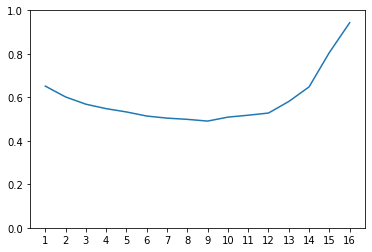

In [42]:
from compmemlearn.analyses import fast_spc
from matplotlib import pyplot as plt

all_spc = []
for subject in pd.unique(trial_details.reset_index().subject):
    all_spc.append(fast_spc(trials[trial_details.reset_index().subject == subject], list_length))

plt.plot(np.mean(np.array(all_spc), 0))
plt.xticks(np.arange(16), np.arange(1, 17))
plt.ylim([0, 1])
np.mean(np.array(all_spc), 0)

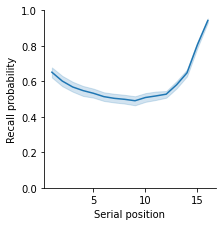

In [35]:
from psifr.fr import spc, plot_spc

plot_spc(spc(events.query(query)))

array([0.05678382, 0.01039305, 0.00642479, 0.00670824, 0.00604686,
       0.00547997, 0.00576342, 0.0068972 , 0.00784203, 0.01247166,
       0.01899093, 0.02636054, 0.05404384, 0.07728647, 0.17602041,
       0.52248677])

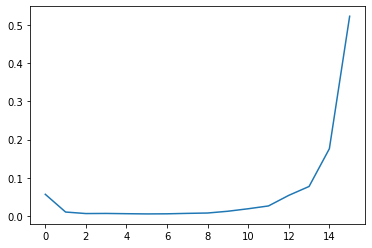

In [36]:
from compmemlearn.analyses import fast_pfr


plt.plot(fast_pfr(trials, 16))
fast_pfr(trials, 16)

array([0.07013015, 0.0449605 , 0.04400144, 0.0428737 , 0.04340568,
       0.04586968, 0.04434903, 0.05034398, 0.05243838, 0.05481084,
       0.05850215, 0.06496167, 0.07911819, 0.10179338, 0.23415122,
       0.        , 0.37368628, 0.11497925, 0.08832226, 0.07665047,
       0.06791563, 0.06555278, 0.06117247, 0.05582643, 0.0575447 ,
       0.05188844, 0.04802974, 0.04777202, 0.05092967, 0.05223637,
       0.06231743])

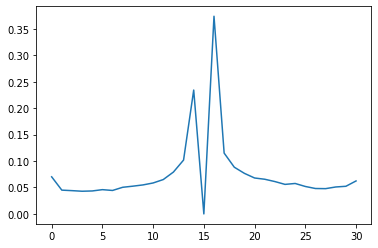

In [37]:
from compmemlearn.analyses import fast_crp

plt.plot(fast_crp(trials, 16))

fast_crp(trials, 16)